In [371]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from matplotlib.patches import Patch, Polygon
from shapely.geometry import Polygon as ShapelyPolygon
from scipy.spatial import HalfspaceIntersection, ConvexHull, QhullError
import itertools

In [372]:
def is_feasible(A, b):
    n = A.shape[1]
    res = linprog(np.zeros(n), A_ub=A, b_ub=b, bounds=(None, None), method="highs")
    return res.success

In [373]:
def is_bounded(A, b, tol=1e-9):
    """
    Correctly determines if the region {x | A x <= b} is bounded.
    Checks if the recession cone {d | A d <= 0} contains a nonzero vector.
    """
    n = A.shape[1]
    c = np.zeros(n)

    # Try to find a non-zero d such that A d <= 0
    res = linprog(c, A_ub=A, b_ub=np.zeros(A.shape[0]), bounds=(None, None), method="highs")

    if not res.success:
        return True  # No feasible direction — bounded
    
    d = res.x
    if np.linalg.norm(d) > tol:
        return False  # Found non-zero direction — unbounded

    return True  # Only solution is d = 0 — bounded

In [374]:
def remove_redundant_constraints(A, b, tol=1e-7):
    m, n = A.shape
    keep = []

    if not is_feasible(A, b):
        raise ValueError("System is infeasible — no region to simplify.")
    if not is_bounded(A, b):
        print("Warning: System is unbounded — proceed with care.")

    for i in range(m):
        A_rest = np.delete(A, i, axis=0)
        b_rest = np.delete(b, i, axis=0)
        a_i, b_i = A[i], b[i]

        res = linprog(-a_i, A_ub=A_rest, b_ub=b_rest, bounds=(None, None), method="highs")

        if not res.success or -res.fun > b_i + tol:
            keep.append(i)

    return A[keep], b[keep]

In [375]:
def get_strictly_inside_point(A, b):
    n = A.shape[1]
    c = np.zeros(n)
    res = linprog(c, A_ub=A, b_ub=b, bounds=[(None, None)] * n, method='highs')
    if not res.success:
        raise ValueError("Region is infeasible")
    return res.x + 1e-14 * np.ones(n)  # Slight nudge to ensure it's interior

In [376]:
# def get_strictly_inside_point(A, b, slack_eps=1e-14):
#     """
#     Returns a point strictly inside Ax <= b, if one exists,
#     by maximizing the minimum slack.
#     """
#     from scipy.optimize import linprog
#     m, n = A.shape
# 
#     # New variables: x (n), t (1)
#     # Maximize t subject to: Ax <= b - t, t >= slack_eps
#     c = np.zeros(n + 1)
#     c[-1] = -1  # Maximize t → minimize -t
# 
#     A_ub_ext = np.hstack([A, -np.ones((m, 1))])  # Ax - t <= b → Ax + (-1)*t <= b
#     b_ub_ext = b - slack_eps
# 
#     bounds = [(None, None)] * n + [(0, None)]  # x unbounded, t ≥ 0
# 
#     res = linprog(c, A_ub=A_ub_ext, b_ub=b_ub_ext, bounds=bounds, method='highs')
# 
#     if res.success:
#         return res.x[:-1]  # Return x part only
#     else:
#         raise ValueError("No strictly feasible point found.")


In [377]:
# def plot_feasible_region(A, b, label="Region", color="blue", alpha=0.3, linestyle='-'):
#     """
#     Visualize a 2D feasible region defined by Ax <= b using HalfspaceIntersection.
#     """
# 
#     if A.shape[1] != 2:
#         raise ValueError("Only 2D regions are supported for visualization.")
# 
#     # Convert to halfspace format [a, -b]
#     halfspaces = np.hstack((A, -b.reshape(-1, 1)))
# 
#     # Get interior point
#     res = linprog(c=np.zeros(2), A_ub=A, b_ub=b, bounds=(None, None), method="highs")
#     if not res.success:
#         print(f"[{label}] Feasible region is empty.")
#         return
#     
#     # interior_point = res.x
#     interior_point = get_strictly_inside_point(A,b)
#     try:
#         hs = HalfspaceIntersection(halfspaces, interior_point)
#         verts = hs.intersections
# 
#         if len(verts) < 3:
#             print(f"[{label}] Region is degenerate (less than 3 vertices). Skipping fill.")
#             return
# 
#         hull = ConvexHull(verts)
#         polygon = Polygon(verts[hull.vertices], closed=True,
#                           facecolor=color, alpha=alpha,
#                           edgecolor='black', linestyle=linestyle,
#                           label=label)
#         plt.gca().add_patch(polygon)
#     except QhullError as e:
#         print(f"[{label}] QhullError: {e}")


In [378]:
# def plot_feasible_region(A, b, label="Region", color="blue", alpha=0.3, linestyle='-'):
#     """
#     Visualize a 2D feasible region defined by Ax <= b using HalfspaceIntersection.
#     """
# 
#     if A.shape[1] != 2:
#         raise ValueError("Only 2D regions are supported for visualization.")
# 
#     try:
#         interior_point = get_strictly_inside_point(A, b)
#     except ValueError:
#         print(f"[{label}] Region is empty or infeasible.")
#         return
# 
#     halfspaces = np.hstack((A, -b.reshape(-1, 1)))
# 
#     try:
#         hs = HalfspaceIntersection(halfspaces, interior_point)
#         verts = hs.intersections
# 
#         if len(verts) < 3:
#             print(f"[{label}] Region is degenerate (less than 3 vertices). Skipping.")
#             return
# 
#         # Sort points counter-clockwise around centroid
#         center = np.mean(verts, axis=0)
#         sorted_verts = sorted(verts, key=lambda p: np.arctan2(p[1] - center[1], p[0] - center[0]))
#         poly = ShapelyPolygon(sorted_verts)
# 
#         # Fix if invalid
#         if not poly.is_valid:
#             poly = poly.buffer(0)
# 
#         if poly.is_empty or not poly.is_valid:
#             print(f"[{label}] Final polygon is invalid or empty.")
#             return
# 
#         # Plot using matplotlib
#         patch = Polygon(np.array(poly.exterior.coords), closed=True,
#                         facecolor=color, alpha=alpha,
#                         edgecolor='black', linestyle=linestyle,
#                         label=label)
#         plt.gca().add_patch(patch)
# 
#     except QhullError as e:
#         print(f"[{label}] QhullError: {e}")

In [379]:
def plot_feasible_region(region_constraints_list, xlim=(0, 10), ylim=(0, 10),
                                 label="Common Region", color="purple", alpha=0.4):
    """
    Plot the intersection of all feasible regions defined by each (A, b) pair in the list.
    """
    # Combine all constraints
    A_all = np.vstack([A for A, b in region_constraints_list])
    b_all = np.hstack([b for A, b in region_constraints_list])

    # Optionally bound it to a known box
    A_box = np.array([
        [-1, 0], [1, 0], [0, -1], [0, 1]
    ])
    b_box = np.array([
        -xlim[0], xlim[1], -ylim[0], ylim[1]
    ])
    A_all = np.vstack([A_all, A_box])
    b_all = np.hstack([b_all, b_box])

    try:
        interior_point = get_strictly_inside_point(A_all, b_all)
    except ValueError:
        print("[Common Region] No feasible intersection.")
        return

    try:
        halfspaces = np.hstack((A_all, -b_all.reshape(-1, 1)))
        hs = HalfspaceIntersection(halfspaces, interior_point)
        verts = hs.intersections

        if len(verts) < 3:
            print("[Common Region] Degenerate region (less than 3 vertices).")
            return

        # Sort vertices for polygon
        center = np.mean(verts, axis=0)
        sorted_verts = sorted(verts, key=lambda p: np.arctan2(p[1] - center[1], p[0] - center[0]))
        poly = ShapelyPolygon(sorted_verts)

        if not poly.is_valid:
            poly = poly.buffer(0)

        if poly.is_empty:
            print("[Common Region] Empty region after polygon fix.")
            return

        patch = Polygon(np.array(poly.exterior.coords), closed=True,
                           facecolor=color, edgecolor='black',
                           alpha=alpha, label=label)
        plt.gca().add_patch(patch)

    except QhullError as e:
        print(f"[Common Region] QhullError: {e}")

In [380]:
def augment_with_bounds(A, b, xlim, ylim):
    # Add constraints for bounding box: x >= xlim[0], x <= xlim[1], y >= ylim[0], y <= ylim[1]
    A_box = np.array([
        [-1, 0],  # -x <= -x_min → x >= x_min
        [1, 0],   # x <= x_max
        [0, -1],  # -y <= -y_min → y >= y_min
        [0, 1]    # y <= y_max
    ])
    b_box = np.array([
        -xlim[0],
         xlim[1],
        -ylim[0],
         ylim[1]
    ])
    
    A_aug = np.vstack([A, A_box])
    b_aug = np.hstack([b, b_box])
    return A_aug, b_aug


In [381]:
def get_polygon_from_halfspaces(A, b, epsilon=1e-5):
    b_strict = b - epsilon
    res = linprog(c=np.zeros(A.shape[1]), A_ub=A, b_ub=b_strict)
    if not res.success:
        raise ValueError("Could not find strictly interior feasible point.")

    interior_point = res.x
    halfspaces = np.hstack([A, -b.reshape(-1, 1)])
    hs = HalfspaceIntersection(halfspaces, interior_point)

    # Sort points in counter-clockwise order to avoid invalid polygon
    center = np.mean(hs.intersections, axis=0)
    sorted_points = sorted(hs.intersections, key=lambda p: np.arctan2(p[1] - center[1], p[0] - center[0]))

    poly = ShapelyPolygon(sorted_points)

    # Fix any topology issues
    if not poly.is_valid:
        poly = poly.buffer(0)

    return poly

In [382]:
def plot_regions_with_overlap(region_constraints_list, xlim=(-10, 10), ylim=(-10, 10)):
    # Create polygons for each region
    region_polygons = []
    for A, b in region_constraints_list:
        A_aug, b_aug = augment_with_bounds(A, b, xlim, ylim)
        poly = get_polygon_from_halfspaces(A_aug, b_aug)
        
        bbox = ShapelyPolygon([(xlim[0], ylim[0]), (xlim[1], ylim[0]),
                (xlim[1], ylim[1]), (xlim[0], ylim[1])])
        
        # Intersect only after ensuring polygon is valid
        if poly.is_valid:
            poly = poly.intersection(bbox)
        else:
            poly = poly.buffer(0).intersection(bbox)
        
        region_polygons.append(poly)

    # Create union of combinations of regions
    region_union_polys = {}
    for r in range(1, len(region_polygons)+1):
        for combo in itertools.combinations(range(len(region_polygons)), r):
            inter_poly = region_polygons[combo[0]]
            for i in combo[1:]:
                inter_poly = inter_poly.intersection(region_polygons[i])
            if not inter_poly.is_empty:
                region_union_polys[combo] = inter_poly

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(region_union_polys) + 1))

    legend_handles = []
    for i, (combo, poly) in enumerate(region_union_polys.items()):
        ax.fill(*poly.exterior.xy, alpha=0.6, color=colors[i], label=f"Overlap: {combo}")
        legend_handles.append(Patch(color=colors[i], label=f"Overlap: {combo}"))

    # Optional: plot boundaries of each region
    for i, poly in enumerate(region_polygons):
        x, y = poly.exterior.xy
        ax.plot(x, y, linestyle='--', label=f'Region {i}', linewidth=1.5)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')
    ax.legend(handles=legend_handles)
    ax.set_title("Region Overlap Visualization")
    plt.grid(True)
    plt.show()

In [392]:
# Example system Ax <= b
A = np.array([
    [ 1,  0],
    [-1,  0],
    [ 0,  1],
    [ 0, -1],
    [ 1,  1]
])
b = np.array([1, 1, 1, 1, 1])

# Reduce
A_red, b_red = remove_redundant_constraints(A, b)
print("Reduced constraints:")
print(f'A: {A_red}')
print(f'b: {b_red}')

Reduced constraints:
A: [[ 1  0]
 [-1  0]
 [ 0  1]
 [ 0 -1]
 [ 1  1]]
b: [1 1 1 1 1]


In [393]:
A_red

array([[ 1,  0],
       [-1,  0],
       [ 0,  1],
       [ 0, -1],
       [ 1,  1]])

In [385]:
# # Plot
# plt.figure(figsize=(6, 6))
# plot_feasible_region(A, b, label="Original", color="blue", alpha=0.3)
# plot_feasible_region(A_red, b_red, label="Reduced", color="red", alpha=0.3, linestyle='--')
# plt.legend()
# plt.title("Original vs Reduced Feasible Region")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.grid(True)
# plt.axis('equal')
# plt.show()

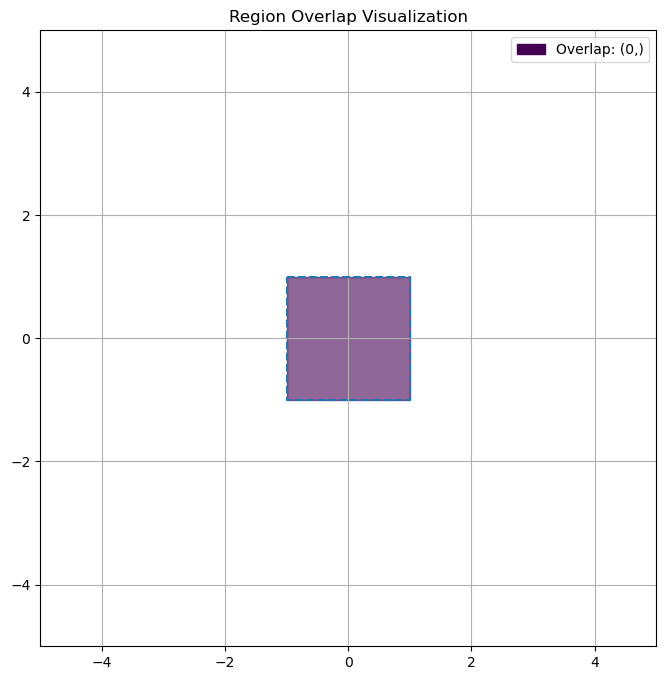

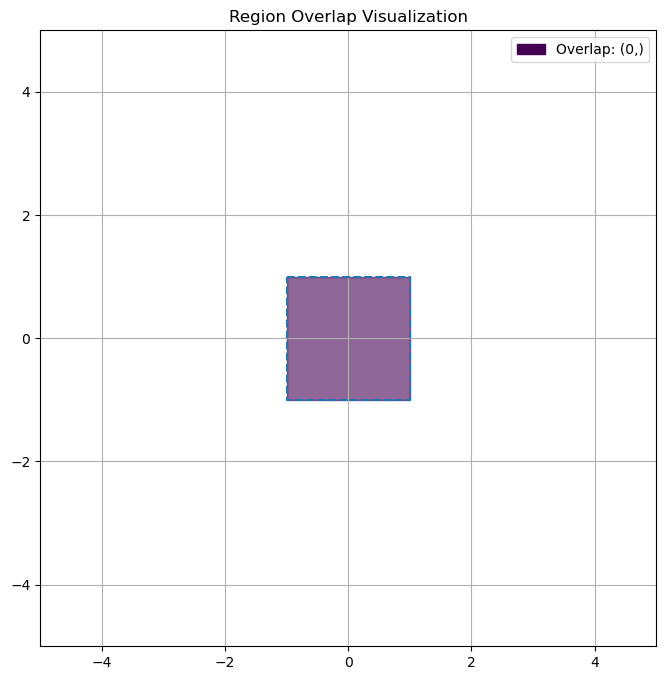

In [386]:
plot_regions_with_overlap(region_constraints_list=[(A, b)], xlim=(-5,5), ylim=(-5,5))
plot_regions_with_overlap(region_constraints_list=[(A_red, b_red)], xlim=(-5,5), ylim=(-5,5))

In [387]:
# Example system Ax <= b
A = np.array([
    [-5, 7],
    [-1, 0],
    [5, 8],
    [1, 0],
    [-1, -1],
    [1, -1],
    [1, 0],
    [-1, 0],
    [0, 1],
    [0, -1]
])
b = np.array([6, -3, 64, 8, -8, 2, 10, 0, 10, 0])

# Reduce
A_red, b_red = remove_redundant_constraints(A, b)
print("Reduced constraints:")
print(f'A: {A_red}')
print(f'b: {b_red}')

Reduced constraints:
A: [[-5  7]
 [ 5  8]
 [-1 -1]
 [ 1 -1]]
b: [ 6 64 -8  2]


In [388]:
# # Plot
# plt.figure(figsize=(6, 6))
# plot_feasible_region(A, b, label="Original", color="blue", alpha=0.3)
# plot_feasible_region(A_red, b_red, label="Reduced", color="red", alpha=0.3, linestyle='--')
# plt.legend()
# plt.title("Original vs Reduced Feasible Region")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.grid(True)
# plt.axis('equal')
# plt.show()

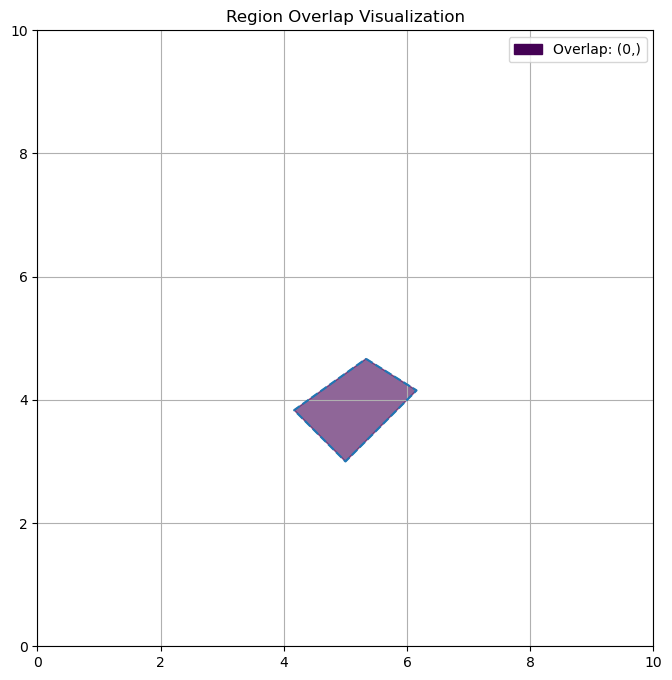

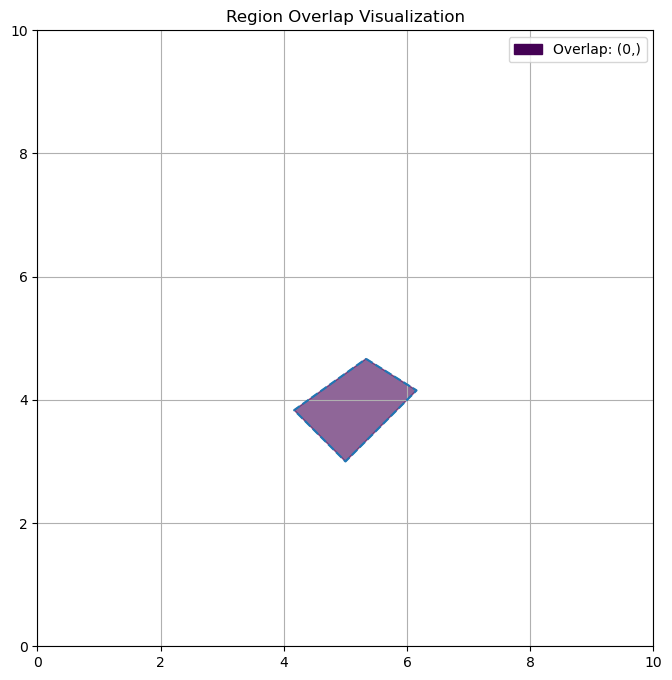

In [389]:
plot_regions_with_overlap(region_constraints_list=[(A, b)], xlim=(0,10), ylim=(0,10))
plot_regions_with_overlap(region_constraints_list=[(A_red, b_red)], xlim=(0,10), ylim=(0,10))